In [79]:
import numpy as np
from Bio.PDB import PDBList, Superimposer, is_aa, DSSP, HSExposureCB, PPBuilder
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.DSSP import DSSP
import matplotlib.pyplot as plt
from matplotlib import patches
import requests
import math
import json

In [80]:
feature_folder = "./features/"
dist_mat_folder = feature_folder + "distance_matrices/"
kdssp_folder='/home/anaconda3/envs/bioPython/bin/mkdssp'
data_folder='./data/'
pdb_id='PED00153e007'

In [81]:
structure = PDBParser(QUIET=True).get_structure(pdb_id, "data/{}.pdb".format(pdb_id))

In [82]:
len(structure)

200

In [83]:
def extract_ss_feature(inpt_structure,pdb_id):
    
    # List of Ramachandran areas corresponding to different secondary structure classes
# E = beta sheet, P = polyproline I && II,
# H = alpha-helix, R = left-handed helix
# (lower-left phi and psi, width, height, class, color)
    rama_ss_ranges = [(-180, -180, 80, 60, 'E', 'blue'),
                      (-180, 50, 80, 130, 'E', 'blue'),
                      (-100, -180, 100, 60, 'P', 'green'),
                      (-100, 50, 100, 130, 'P', 'green'),
                      (-180, -120, 180, 170, 'H', 'red'),
                      (0, -180, 180, 360, 'L', 'yellow')]
    
    num_struct= len(inpt_structure)
    
    # Calculate PSI and PHI
    ppb = PPBuilder()  # PolyPeptideBuilder
    rama = {}  # { chain : [[residue_1, ...], [phi_residue_1, ...], [psi_residue_2, ...] ] }
    for i_mod,model in enumerate(structure):
        for chain in model:
            for pp in ppb.build_peptides(chain):

                phi_psi = pp.get_phi_psi_list()  # [(phi_residue_1, psi_residue_1), ...]
                for i, residue in enumerate(pp):
                # print(model, chain, i, residue, phi_psi[i])

                # Convert radians to degrees and remove first and last value that are None
                    if phi_psi[i][0] is not None and phi_psi[i][1] is not None:
                        rama.setdefault((chain.id,i_mod ),[[], [], [],[]])
                        rama[(chain.id,i_mod)][0].append(residue.id)
                        rama[(chain.id,i_mod)][1].append(math.degrees(phi_psi[i][0]))
                        rama[(chain.id,i_mod)][2].append(math.degrees(phi_psi[i][1]))
                        
                        for x,y,w,h,ss_c,color in rama_ss_ranges:
                            if x <= phi_psi[i][0] < x + w and y <= phi_psi[i][1] < y + h:
                                rama[(chain.id,i_mod)][3].append(ss_c)
                                break
                        
    file_name=pdb_id+"_rama.txt"
    with open(file_name,"w") as file:
        file.write(str(rama))
        
       
                        
    return rama
    
    
    

In [85]:
rama_1= extract_ss_feature(structure,pdb_id)

In [39]:
#rama_1[('A',0)][3]

In [66]:
def read_ramaFeature(file_name):
    
    output=''
    
    with open(file_name,'r') as file:
        for i in file.readlines():
            output=i
    
    output=eval(output)
    
    return output
    
    

In [69]:
rama_2= read_ramaFeature(pdb_id+"_rama.txt")
#rama2.keys()
#rama2.values()

In [136]:
def ss_entropy_calc(inpt_rama):
    
    output={}
    
    chains_list=list(np.unique([key[0] for key in inpt_rama.keys()]))
    
    num_mod4chain=[]
    
    for chain in chains_list:
        num_mod4chain.append(len([key  for key in inpt_rama.keys() if key[0]=='A']))
    
    #key=residue_id, value=>list=[E,P,H,L,nn,entropy,number of conformation for each residue]
    #output.setdefault((chain_id,residue_id),[,,,,])
    i=0
    for i_chain,chain in enumerate(chains_list):
        
        output[chain]={}
        
        for int_mod in range(0,num_mod4chain[i_chain]):
            for residue in inpt_rama[(chain,int_mod)][0]:
                #output[chain].setdefault(residue,[0,])
                              
                if not(residue in output[chain]):
                    output[chain][residue]=[0,0,0,0,0,0,0]
            
                
                ss_residue=inpt_rama[(chain,int_mod)][3]
                output[chain][residue][6]+=1
                #print(type(ss_residue))
                if ss_residue[0]=='E':
                    output[chain][residue][0]+=1
                elif ss_residue[0]=='P':
                    output[chain][residue][1]+=1
                elif ss_residue[0]=='H':
                    i+=1
                    output[chain][residue][2]+=1
                elif ss_residue[0]=='L':
                    output[chain][residue][3]+=1
                else:
                    print(ss_residue)
                    output[chain][residue][4]+=1
                    
        for residue in output[chain]:
            
            output[chain][residue]=np.array(output[chain][residue],dtype=np.float)/output[chain][residue][6]
            log_frq=np.array([1,1,1,1,1],dtype=np.float)
            for i in range(5):
                if output[chain][residue][i] !=0:
                    log_frq[i]=np.log(output[chain][residue][i])
            output[chain][residue][5]=np.sum(-output[chain][residue][0:5]*log_frq)
            
            
    file_name=pdb_id+"_ss_freq_entropy.txt"
    with open(file_name,"w") as file:
        file.write(str(output))

    return output
                    


In [137]:
prova=ss_entropy_calc(rama_2)

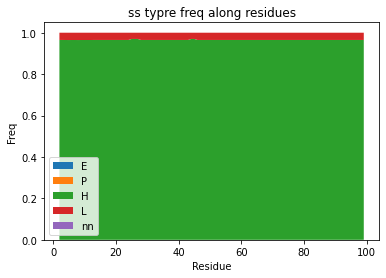

In [143]:
x=[item[1] for item in list(prova['A'].keys())]
ss_res={}
ss_res['E']=[item[0] for item in prova['A'].values()]
ss_res['P']=[item[1] for item in prova['A'].values()]
ss_res['H']=[item[2] for item in prova['A'].values()]
ss_res['L']=[item[3] for item in prova['A'].values()]
ss_res['nn']=[item[4] for item in prova['A'].values()]


fig, ax = plt.subplots()
ax.stackplot(x, ss_res.values(),
             labels=ss_res.keys())

ax.legend(loc='lower left')
ax.set_title('ss typre freq along residues')
ax.set_xlabel('Residue')
ax.set_ylabel('Freq')
plt.show()

In [5]:
dssp = DSSP(structure[0], "data/{}.pdb".format(pdb_id), dssp='mkdssp') 
dssp_dict = dict(dssp)

In [7]:
 for ss in dssp:
     #dssp index, amino acid, secondary structure, relative ASA, phi, psi,
     #NH_O_1_relidx, NH_O_1_energy, O_NH_1_relidx, O_NH_1_energy,
     #NH_O_2_relidx, NH_O_2_energy, O_NH_2_relidx, O_NH_2_energy
     #print(ss)

SyntaxError: unexpected EOF while parsing (<ipython-input-7-047a74f87a34>, line 5)

In [23]:
# List of Ramachandran areas corresponding to different secondary structure classes
# E = beta sheet, P = polyproline I && II,
# H = alpha-helix, R = left-handed helix
# (lower-left phi and psi, width, height, class, color)
rama_ss_ranges = [(-180, -180, 80, 60, 'E', 'blue'),
                  (-180, 50, 80, 130, 'E', 'blue'),
                  (-100, -180, 100, 60, 'P', 'green'),
                  (-100, 50, 100, 130, 'P', 'green'),
                  (-180, -120, 180, 170, 'H', 'red'),
                  (0, -180, 180, 360, 'L', 'yellow')]

In [10]:



# Calculate PSI and PHI
ppb = PPBuilder()  # PolyPeptideBuilder
rama = {}  # { chain : [[residue_1, ...], [phi_residue_1, ...], [psi_residue_2, ...] ] }
for i_mod,model in enumerate(structure):
    for chain in model:
        for pp in ppb.build_peptides(chain):

            phi_psi = pp.get_phi_psi_list()  # [(phi_residue_1, psi_residue_1), ...]
            for i, residue in enumerate(pp):
                # print(model, chain, i, residue, phi_psi[i])

                # Convert radians to degrees and remove first and last value that are None
                if phi_psi[i][0] is not None and phi_psi[i][1] is not None:
                    rama.setdefault((chain.id,i_mod ),[[], [], []])
                    rama[(chain.id,i_mod)][0].append(residue)
                    rama[(chain.id,i_mod)][1].append(math.degrees(phi_psi[i][0]))
                    rama[(chain.id,i_mod)][2].append(math.degrees(phi_psi[i][1]))


In [43]:
dssp_dict[('A', (' ', 1, ' '))]
len(dssp_dict.values())

100

In [35]:
# Get SS from phi/psi and compare with DSSP
for (chain_id,i_mod) in rama:
    for residue, phi, psi in zip(*rama[(chain_id,i_mod)]):
        ss_class = None
        for x, y, width, height, ss_c, color in rama_ss_ranges:
            if x <= phi < x + width and y <= psi < y + height:
                ss_class = ss_c
                break
        #print(residue, ss_class, dssp_dict.get((chain_id, residue.id))[2], phi, psi)
        print(residue.get_resname(),residue.id[1] ,ss_class, dssp_dict.get((chain_id, residue.id))[2], phi, psi)
        

ALA 2 L - 69.20498269346855 6.826442717955578
ALA 3 P - -62.04812787252673 141.89482440674956
SER 4 E - -102.8833203162628 143.50757734731553
SER 5 E - -144.78886689611187 126.18866973661765
LEU 6 H - -73.37218816451369 -28.197132788566055
GLU 7 P - -55.72614633487897 138.05432578381323
GLN 8 E - -135.93018641130644 154.38551511412618
LYS 9 H S -65.25196707278886 -25.172304936070578
LEU 10 P S -69.63924397551551 152.18149963689882
SER 11 H S -97.29355358825762 0.5716015164298957
ARG 12 E - -148.29729676028472 146.87860293942015
LEU 13 H S -73.84087040923943 -41.862297922797005
GLU 14 P - -54.56524573545403 150.48840173460823
ALA 15 E - -158.87979055152553 68.04972394774036
LYS 16 P - -77.2405705363252 126.05405642167285
LEU 17 H S -67.64188830684624 -26.888113506765226
LYS 18 P - -70.97865949013428 151.97237837628543
GLN 19 E - -121.69960623224543 169.17860659506619
GLU 20 P - -63.069692278139364 141.58410346878907
ASN 21 P - -68.48717876490518 145.7064192082882
ARG 22 P - -46.47888380

PRO 56 H - -72.78671874357633 -5.516708360622567
SER 57 H - -84.87728662412417 -6.22502379169493
SER 58 P S -67.8190320549251 151.95573937375127
GLU 59 H S -71.05171590398209 -25.28222223491283
SER 60 P S -59.966562815200824 136.51819453029592
SER 61 E - -134.83603999912722 71.70664218775326
PRO 62 H S -93.32290935810721 3.2561820884633477
GLN 63 H S -95.63618075183685 -1.1525500486812799
HIS 64 E - -140.570829902697 76.93683923405425
PRO 65 P S -66.90018137449005 152.6054271723929
THR 66 E S -132.8864193308709 70.59085791572475
PRO 67 P - -78.45611093082321 157.4395569209597
PRO 68 P S -62.96339579525704 141.5970771733572
ALA 69 P S -55.57324230751635 134.89987618028897
ARG 70 E - -111.61817923540319 96.2223801995092
PRO 71 H - -70.20303492595272 -14.587801426943773
ARG 72 P - -81.5418761868756 93.02197726214065
HIS 73 E - -129.28833515500926 167.59509099103326
MET 74 H - -83.59112330246126 6.307041619751034
LEU 75 E - -126.18597947289958 146.4162359717438
GLY 76 L S 87.7658600374327 

GLY 52 H T -89.33526172543615 4.857615564990891
SER 53 P S -70.90913231132069 156.9150395015946
ARG 54 P - -99.17540021660103 146.07352875905804
SER 55 E - -160.91735450653394 64.99361198942633
PRO 56 P - -62.22378688506157 138.12140665836625
SER 57 E - -133.16457073771213 139.96070475693983
SER 58 P S -60.034923597533144 136.52435484662533
GLU 59 H S -64.87432762190437 -35.725908644341565
SER 60 P S -56.48373942050402 146.22981611924166
SER 61 E - -146.55428005765114 63.709301033985895
PRO 62 H S -71.92411546085403 -7.800515829980835
GLN 63 H S -60.159777148063654 -35.138058014405615
HIS 64 P - -92.52871985587504 100.11593741373085
PRO 65 H S -59.73608299613286 -29.412521909280912
THR 66 E S -131.693446822194 71.41250326491406
PRO 67 P - -50.230161719832424 143.79130179431073
PRO 68 P S -75.62096511881539 60.360659479741365
ALA 69 H S -89.80436375216942 7.179011120303467
ARG 70 P - -91.61542399166517 149.2683086827413
PRO 71 P - -52.36762287063839 120.98648678879937
ARG 72 H - -101.87

PRO 65 P S -68.22313649146061 127.13709357877413
THR 66 E S -116.19621613716119 156.3291403046309
PRO 67 P - -61.55317796605727 152.2074086044649
PRO 68 H S -59.954640736711426 -20.418926343750066
ALA 69 H S -64.91594595856559 -41.459885352437055
ARG 70 E - -149.36733788965262 75.92697545965649
PRO 71 H - -69.36524471448374 -4.411773031988438
ARG 72 P - -45.01055374462257 119.80171492842365
HIS 73 E - -129.21853464760414 68.40901354960224
MET 74 E - -134.20481126828017 140.46839424794808
LEU 75 H - -81.4146423046811 -8.79685010032936
GLY 76 P S -90.41174982682953 105.02564753093954
LEU 77 P S -64.28315706762058 115.4005494097357
PRO 78 P - -63.94363975550033 157.82852753629805
SER 79 H S -93.73265208638304 -4.019838881697859
THR 80 E S -172.37696613183832 156.29327254699297
LEU 81 E - -108.10305841451013 155.1415085080412
PHE 82 H - -98.77421949996538 10.545155356016284
THR 83 P - -79.3273320605286 141.88350325536055
PRO 84 P T -72.97904414839564 147.2801748149918
ARG 85 E T -127.48008

THR 42 H S -68.532270110006 -17.406649175767836
LEU 43 P - -86.20006422721738 161.48907185324867
GLN 44 E S -108.31135380881756 174.12242736197513
LEU 45 H S -83.72324478115654 -43.72927398160505
PRO 46 P - -77.01461021098018 143.248752887108
LEU 47 H - -68.05006735046412 -31.985343703916445
ALA 48 E - -110.56731084012152 146.7037713726197
ASN 49 H - -152.4826265115831 34.15489550415026
ASP 50 E - -165.49861914236482 65.97524765372924
GLY 51 L T 174.74226445047975 176.45970791961918
GLY 52 H T -118.73317043183074 -13.997436480681799
SER 53 E S -105.59594555754992 124.03016151291459
ARG 54 P - -58.12452679780694 135.47815991389538
SER 55 P - -64.90771313861806 167.1035465674798
PRO 56 H - -71.9081530214772 -7.785817671187753
SER 57 L - 55.70719843483647 45.236805483727686
SER 58 H S -126.61728286492519 10.882439427679925
GLU 59 H S -60.794651728612116 -42.20039373357287
SER 60 H S -76.30150532932063 -4.785844483807207
SER 61 E - -129.50458582800792 66.67635578259036
PRO 62 P S -55.55427

PRO 39 P - -61.31352145805039 142.18632561874637
ARG 40 P - -85.31774007069227 157.2974255001653
PRO 41 P - -53.016818114882135 141.82256984456765
THR 42 E S -141.76218563470331 -179.48779300081972
LEU 43 E - -125.1249742184951 165.56878705032094
GLN 44 P S -78.2640241365447 147.45255279199242
LEU 45 P S -88.96808590576042 153.99310195689375
PRO 46 P - -74.27514737513076 151.16573374012268
LEU 47 P - -65.60562598489571 150.3007911504353
ALA 48 H - -110.78295285965542 8.374146123010815
ASN 49 P - -87.23675287461613 159.21033355512526
ASP 50 P - -70.92258056331242 116.81281267081701
GLY 51 L T 52.958340525874966 -135.37788181541046
GLY 52 L T 59.87511224277783 13.29973651602663
SER 53 E S -158.77963258309447 -172.57844135916184
ARG 54 H - -91.67403713696216 4.259628244892394
SER 55 P - -65.71109695432438 151.7429535418039
PRO 56 P - -65.34576743871237 146.70582179179203
SER 57 H - -67.32949545572752 -16.907270866799948
SER 58 P S -69.19751722504945 151.89509578143378
GLU 59 E S -120.3958

GLU 23 H - -65.23214963616046 -33.540915078059065
ALA 24 H S -65.75828855166698 -42.65281111216186
ARG 25 H S -66.10411758396253 -36.95463070323577
ARG 26 H S -57.68401259428462 -41.79062687825574
ARG 27 H - -61.79142979680295 -36.95423452537798
ILE 28 H S -64.84967037153389 -40.932496886451524
ASP 29 H S -63.65004986048347 -37.22568791574068
LEU 30 H S -66.93318072136495 -39.67552153504679
ASN 31 H S -80.43284515913525 -12.951121861077047
LEU 32 H - -96.42265648739458 -29.41521036079428
ASP 33 H S -79.2967373476106 -38.75298710127591
ILE 34 E - -145.0134836392056 152.35930584832255
SER 35 E - -134.66957467736938 158.12355559068476
PRO 36 P - -52.394730227795975 158.90717715410582
GLN 37 H S -68.4163617913207 -36.44568512971045
ARG 38 P S -85.26170218754586 157.25537978398003
PRO 39 P - -77.03088915929888 174.94314206890303
ARG 40 P - -67.36955715781001 165.69585101844723
PRO 41 P - -60.29104871460198 146.4950340905053
THR 42 P S -48.328027366291856 120.97915841175126
LEU 43 E - -139.1

GLY 76 L S 129.51556310617815 131.39052244559545
LEU 77 P S -71.77978132342064 161.19503047389145
PRO 78 H - -75.1865257992375 -18.835773966337772
SER 79 P S -72.98279958625812 166.5604429258979
THR 80 H S -99.77437715802564 2.6930715448078826
LEU 81 P - -70.04289525632657 146.38263654809884
PHE 82 P - -91.77861647855164 113.82052578123519
THR 83 E - -115.89271938309163 108.37918584690455
PRO 84 P T -61.864794564170374 137.44009410974667
ARG 85 E T -158.6686413095866 161.6238095306355
SER 86 L S 42.635943811717475 42.28921900076717
MET 87 H S -84.35291300453261 4.484781023167854
GLU 88 H - -83.50756258591619 -13.377395596121467
SER 89 H - -103.9975762484308 -8.66677987910718
ILE 90 H - -68.70777199131336 -8.432209103832069
GLU 91 H - -63.565800173555715 -42.22376851851541
ILE 92 P S -50.11051756351796 133.08509741134046
ASP 93 P S -73.7170523653343 159.25766085204617
GLN 94 P - -95.74228769274525 127.54386953424697
LYS 95 P - -55.417174986628574 120.83099901502575
LEU 96 P S -68.389475

LEU 45 P S -64.60260606743448 131.63712985530685
PRO 46 P - -85.62682573476589 166.90015722728165
LEU 47 E - -142.56318456940295 145.1175440513996
ALA 48 H - -124.87718137840493 23.072717709455752
ASN 49 E - -144.8149689664541 118.15264263552362
ASP 50 P - -96.73139801913194 173.92285560871264
GLY 51 H T -78.03979599586272 -9.107611096352784
GLY 52 P T -44.64231497025146 120.48393426257834
SER 53 H S -130.43970317290083 -27.25855704749143
ARG 54 H - -105.01836543820755 2.874202419476542
SER 55 E - -133.11629281548738 67.78758028188979
PRO 56 P - -69.44647253536205 148.84066179820465
SER 57 P - -73.59691950484746 132.60188885562266
SER 58 H S -88.33998156458806 3.98070304505384
GLU 59 P S -68.7835171827312 152.6453885042941
SER 60 H S -75.89421830163327 -10.942820116280055
SER 61 E - -146.75348460034039 152.48075232866822
PRO 62 P S -77.90620751137742 169.55342066895048
GLN 63 P S -89.05225775911478 77.33252416199022
HIS 64 E - -108.3812315303497 101.77407331693684
PRO 65 P S -68.397985

MET 87 H S -83.55254862711497 -9.98367627984796
GLU 88 P - -69.11566809304472 148.31965725144977
SER 89 P - -87.30579201710447 161.02438973280042
ILE 90 P - -73.97211389214635 125.10967892376232
GLU 91 H - -85.47662745590424 -4.586029871115258
ILE 92 H S -79.696407302755 2.7236943714214292
ASP 93 P S -81.17935237108219 82.67767774675453
GLN 94 H - -104.21900430476613 7.247920198751619
LYS 95 P - -66.38966148804484 141.13331901082455
LEU 96 H S -106.61449680897223 -0.5731180596787435
GLN 97 P S -66.29719132898623 140.35499692313408
GLU 98 P - -62.94080232262499 148.71794391736597
ILE 99 P - -74.86274865028636 107.72602313542325
ALA 2 P - -88.23091996343078 158.17442601716354
ALA 3 P - -89.11530988297896 122.1627598463732
SER 4 H - -108.5413699278022 -9.909851416993941
SER 5 H - -60.62564643283004 -38.74226450099277
LEU 6 H - -31.590867152908533 -67.18459969109638
GLU 7 L - 57.45632241468207 35.78079126149515
GLN 8 P - -69.3221885377109 129.68472335860534
LYS 9 P S -96.97542008121242 105

SER 61 E - -124.52888624354117 75.90732212223492
PRO 62 P S -67.41825481998953 153.43246280239813
GLN 63 P S -88.53936133422016 162.635646579928
HIS 64 E - -108.3758976526055 101.84635002046892
PRO 65 P S -68.35946433486376 145.80761149665614
THR 66 E S -148.19218142066072 96.50730929097917
PRO 67 P - -49.72066033707652 141.4363871958511
PRO 68 P S -70.48286166744367 168.19347113506834
ALA 69 P S -93.64480510007253 87.21358533730827
ARG 70 P - -67.87677233207555 156.90070937887134
PRO 71 P - -82.16853229098129 -170.71816190683577
ARG 72 E - -131.74723691581377 154.36667337853797
HIS 73 P - -54.18442784046495 123.29389618237153
MET 74 P - -83.20108548545282 68.14611484606858
LEU 75 H - -82.87304268097373 -15.605622478727511
GLY 76 L S 92.6157432117561 -5.572469047169321
LEU 77 L S 45.19690115103436 56.99464538787116
PRO 78 P - -85.31001672666123 165.6464562325557
SER 79 L S 48.000174505350905 45.07031275731383
THR 80 H S -125.49007238195261 -7.570509824799549
LEU 81 P - -65.004894442527

PRO 56 P - -88.26775592387594 -176.02889845734796
SER 57 H - -79.79700458826568 -10.027918406972331
SER 58 H S -97.52536478381644 20.010195971207732
GLU 59 H S -54.92854691493922 -11.324192326620452
SER 60 E S -114.12861270655742 115.3858980231927
SER 61 E - -144.612123455145 64.43839325158619
PRO 62 P S -55.76224248080874 130.846103013806
GLN 63 P S -60.25807796012313 152.42711539377183
HIS 64 E - -125.58176691602172 74.43643548084037
PRO 65 P S -52.38884354214462 144.17429713749866
THR 66 P S -57.73478819132315 134.73284612228005
PRO 67 P - -74.61010008575998 147.2147795756406
PRO 68 P S -76.94471402057484 168.75704877904192
ALA 69 P S -68.96696986217206 139.93877377289363
ARG 70 E - -104.13553096472646 97.53350502724709
PRO 71 P - -71.1391971023919 172.90196171372708
ARG 72 L - 54.32632319283926 50.82101070556546
HIS 73 P - -54.596694456767416 128.1988297931892
MET 74 P - -83.49560429146776 68.27360273073849
LEU 75 P - -86.84539031955663 151.31278380904274
GLY 76 P S -59.62912527733

SER 11 P S -68.57526304402431 153.64945979323886
ARG 12 P - -79.42576260576915 73.11209099176456
LEU 13 P S -94.16784297778177 133.42865905932487
GLU 14 H - -83.68168378014366 -30.958727033041765
ALA 15 P - -67.52277143863921 134.29051313332468
LYS 16 H - -63.72906031461873 -34.814441003895254
LEU 17 L S 65.30569501629344 6.496866582480648
LYS 18 E - -138.10691829432406 134.1113339523603
GLN 19 P - -72.74784740738556 156.33318095044893
GLU 20 E - -127.55569612478561 66.42873225055463
ASN 21 H - -130.74601405573048 20.405342012735474
ARG 22 H - -108.29033992260982 0.33745625064960677
GLU 23 H - -71.18841099093515 -15.533366217321255
ALA 24 H S -81.13408176759155 -3.047863713971057
ARG 25 H S -96.19889704082101 -23.273762471386885
ARG 26 P S -79.3792879673053 142.58333563656416
ARG 27 E - -137.52719554486964 155.96939951046747
ILE 28 H S -95.22624068748216 -1.1158521079398114
ASP 29 P S -76.25643031018677 151.09340221053264
LEU 30 H S -142.9891776083173 9.888997011906817
ASN 31 E S -124.

LEU 17 P S -81.91210695197678 80.7373549962381
LYS 18 E - -151.8433106087251 115.03402165617572
GLN 19 H - -95.69067443913869 -1.1003665100875746
GLU 20 E - -120.39241308167735 152.10102375404165
ASN 21 P - -59.771545113789536 134.18741314601576
ARG 22 P - -64.02481447106302 141.7605009809572
GLU 23 E - -142.17440426661082 136.71727312676313
ALA 24 H S -100.21856129144523 8.192444818751394
ARG 25 H S -87.46584066003054 -7.366904425020086
ARG 26 P S -70.2362328839018 158.28521721867452
ARG 27 E - -153.64151821645163 168.9687580010191
ILE 28 E S -146.1451046208663 155.78603537781004
ASP 29 L S 53.44070728302204 65.86333125272493
LEU 30 H S -97.83159013318638 -12.064575883841774
ASN 31 L S 55.33609678986452 51.21162598999769
LEU 32 P - -93.8276499879043 179.0832595528875
ASP 33 H S -63.354071488402994 -24.223790945776905
ILE 34 E - -117.9443940074189 122.01271696190125
SER 35 P - -80.50589818446399 145.41722724377715
PRO 36 H - -61.10321858460299 -17.14696919655181
GLN 37 P S -85.27273950

ALA 2 P - -85.96577300630973 67.65377370543278
ALA 3 H - -60.59903503908222 -22.28987614767439
SER 4 E - -125.19340835385566 153.58185472362814
SER 5 P - -78.80777390343482 153.78254176591875
LEU 6 E - -107.2891172236819 168.54105498222268
GLU 7 E - -100.5520886523713 131.93919573023555
GLN 8 E - -152.2710860168774 168.72929307841773
LYS 9 P S -65.37268254557306 140.7576876438261
LEU 10 E S -104.02770749709396 158.05244537316298
SER 11 P S -65.64159316716545 145.06067813694074
ARG 12 P - -80.04512042814143 -166.06796880171842
LEU 13 L S 50.3291347469826 68.0720726409173
GLU 14 H - -60.37641305062205 -27.87084707993717
ALA 15 E - -148.41755592741376 142.7663863523037
LYS 16 P - -77.32005660894177 126.10989816594879
LEU 17 H S -110.461886600253 -3.3230160131427224
LYS 18 P - -91.8934513878946 133.07726972440392
GLN 19 P - -69.33006068974628 129.6770782827117
GLU 20 E - -150.44055318601198 163.2842574484447
ASN 21 P - -68.46419177423364 145.7120256795375
ARG 22 P - -66.93612805570946 157.

LEU 45 P S -96.30140467639501 157.91259087639693
PRO 46 H - -86.12221706595531 -15.663608952007133
LEU 47 P - -81.78389936605933 141.00112200486032
ALA 48 P - -59.64086826762666 119.36482009678896
ASN 49 E - -121.38801904484359 165.4290524043482
ASP 50 H - -97.84800801428682 5.672161353188087
GLY 51 P T -65.6625471494475 142.3015009892567
GLY 52 L T 63.477751065085734 -114.80077883866882
SER 53 P S -55.12198034091851 141.24336755971302
ARG 54 P - -98.86589383839633 104.55117646914593
SER 55 P - -77.16761067109428 152.7254653705753
PRO 56 P - -68.76882058876986 157.1663652576342
SER 57 L - 45.24418378756756 48.2921593459324
SER 58 P S -81.17350616457504 151.3505022362647
GLU 59 E S -125.02832623298141 75.40367332442541
SER 60 P S -92.67039369025444 144.6626778588321
SER 61 E - -134.2013917980419 161.24048292664853
PRO 62 P S -74.85404821911072 178.71888396571595
GLN 63 H S -99.45845197613649 16.916993187003115
HIS 64 E - -125.63416145219836 74.55764359921018
PRO 65 P S -56.6849917769891

GLU 20 P - -93.02381271066723 162.86218903373774
ASN 21 E - -167.28157560571586 128.58389362392205
ARG 22 E - -167.02845700988752 164.19541454798195
GLU 23 P - -62.123223938727314 141.4429062801191
ALA 24 P S -79.471658892272 61.26261575000781
ARG 25 P S -86.74501060891237 152.35956557984989
ARG 26 E S -113.88850913922421 149.14423256549338
ARG 27 P - -59.978670699928365 139.6515879295724
ILE 28 E S -134.3931189900498 -176.7739911840378
ASP 29 E S -103.951467316212 95.58781439521708
LEU 30 P S -97.4709031247992 105.2733718198515
ASN 31 E S -129.8405860790118 58.3536342717656
LEU 32 P - -70.57387324417644 131.6073693160061
ASP 33 H S -64.1887606162763 -32.95399336834417
ILE 34 E - -114.9972474013834 138.00298447349675
SER 35 P - -82.90036390839889 152.34384160035427
PRO 36 P - -71.81488227309998 170.7694167654518
GLN 37 P S -98.01522523392693 71.93662260861602
ARG 38 P S -85.6465975562786 158.55293008540232
PRO 39 P - -63.27214989584865 145.47886993269648
ARG 40 E - -146.29714600946096 

SER 11 E S -130.31018050273062 163.7810626677846
ARG 12 P - -57.41922726001196 117.06586471823846
LEU 13 H S -91.86757017600812 4.969272740433634
GLU 14 H - -95.06496954976551 -0.5703827036286807
ALA 15 P - -72.53790513652389 143.79146418763503
LYS 16 P - -89.73534437899187 142.12234443276532
LEU 17 E S -115.62100545623797 115.13400542244634
LYS 18 E - -158.35706960172743 101.00130421703055
GLN 19 L - 49.85663044022152 43.81798569380311
GLU 20 H - -82.23011175543716 -8.487019908783939
ASN 21 H - -120.9639334863659 -89.53865321129379
ARG 22 P - -82.86488228682276 138.3966954776046
GLU 23 L - 63.91498871823366 39.53867550064129
ALA 24 H S -81.36661787771943 -34.40513490414787
ARG 25 H S -52.92394194603767 -52.22314002224942
ARG 26 P S -51.3520015388848 138.4833337861257
ARG 27 E - -117.95707793776236 109.30227293424798
ILE 28 E S -117.6580271387033 127.78490997598759
ASP 29 P S -98.68596385825022 102.9713730353015
LEU 30 E S -149.09578254009455 128.57957914647363
ASN 31 P S -90.771278929

ARG 85 P T -55.96890371685248 128.9250320318576
SER 86 H S -125.56360152496744 -0.7693112744861637
MET 87 H S -54.94360294282837 -30.8242135474074
GLU 88 H - -60.85617414887622 -30.5277442755878
SER 89 P - -57.23089979404473 123.51423213636691
ILE 90 P - -73.42206580880242 145.80031864604027
GLU 91 H - -117.52466665478593 2.755459495442201
ILE 92 H S -58.72149113692857 -33.107175818368944
ASP 93 P S -73.62561515038445 159.30267951561365
GLN 94 P - -94.02076712579527 84.9324615342294
LYS 95 P - -96.95150472178005 107.53553463396885
LEU 96 H S -74.34883383831793 -11.87668884966563
GLN 97 P S -88.61856250210165 164.47690599366015
GLU 98 E - -143.30103363189002 139.75925492325703
ILE 99 P - -78.09027422502794 140.05911680232256
ALA 2 E - -135.45597300228144 53.900384539488826
ALA 3 P - -72.07257579306308 145.93843990504683
SER 4 H - -56.151329605174325 -18.994996296383725
SER 5 H - -70.50916436900256 -20.834490962377608
LEU 6 L - 72.72511590403032 -61.46846291969249
GLU 7 E - -117.57505265

SER 57 P - -65.53683767770686 131.46793061784365
SER 58 E S -133.82818633417128 158.08284377233264
GLU 59 E S -124.89516785932587 75.20236154351436
SER 60 L S 49.35383013547361 52.98704459783855
SER 61 E - -132.41960243379668 90.34877385503374
PRO 62 P S -78.29249536203353 166.3509527878363
GLN 63 H S -100.3753985630597 8.842175808255991
HIS 64 E - -138.95124208799163 81.44702291873001
PRO 65 P S -54.80345679087991 156.60999318532956
THR 66 P S -67.57446498016196 158.76155533126803
PRO 67 P - -63.40153136600827 142.81505826407536
PRO 68 P S -61.0660998458107 134.39741971060866
ALA 69 P S -52.608278372916494 146.3055993759001
ARG 70 P - -95.9089640628499 163.16784840239268
PRO 71 P - -60.706910729087326 149.6798963188962
ARG 72 H - -75.9694858438841 -36.78321273943982
HIS 73 E - -161.56727162572994 134.36786957640058
MET 74 H - -52.18907397798254 -45.62721871373618
LEU 75 P - -92.13943106583784 168.41531478538403
GLY 76 H S -59.79555135101067 -32.37733243397235
LEU 77 P S -79.5682985066

GLN 97 P S -74.98541507317935 171.60507041497007
GLU 98 P - -62.98004609575779 148.62125529168625
ILE 99 P - -97.62017589525725 70.70386038523367
ALA 2 P - -66.22798718807856 137.85217164715834
ALA 3 P - -81.14208676448837 137.46524434830948
SER 4 L - 44.55024969605034 55.47863243387281
SER 5 H - -59.19203746494033 -42.195800360508116
LEU 6 P - -69.70422203655497 148.88881606708654
GLU 7 P - -60.880430572539204 121.46299853402941
GLN 8 H - -76.55252919154537 -8.841076415435381
LYS 9 E S -107.85471845979671 151.6244260667414
LEU 10 E S -123.93119700735555 133.2780747267258
SER 11 P S -81.22890811344685 151.4081813450426
ARG 12 H - -69.86868492826147 -7.012153842489786
LEU 13 H S -94.23508793693125 -2.0246967023545475
GLU 14 P - -66.58411536920211 152.16355020386547
ALA 15 H - -79.50974803477665 -6.703642333801038
LYS 16 E - -142.83032073607734 143.17197815406365
LEU 17 H S -87.9953525885506 -42.507089254239666
LYS 18 H - -153.15385927659037 -24.49929696144442
GLN 19 E - -100.48444588834

ARG 26 P S -84.28969213174268 152.52706079077183
ARG 27 H - -114.54664607611012 35.04444900273776
ILE 28 H S -76.87336445965506 -19.72087042873878
ASP 29 P S -72.60232511250148 149.946422747189
LEU 30 P S -57.53927725752351 133.84683168447503
ASN 31 P S -79.72826452320204 156.46306288005346
LEU 32 P - -79.83820573141557 148.12461495711315
ASP 33 P S -90.34645855553966 71.40611847546431
ILE 34 P - -65.01740959354122 157.91071286853972
SER 35 E - -134.9013089099744 161.21067266067527
PRO 36 P - -68.6043718180363 143.2967342907445
GLN 37 H S -122.55760455901114 43.40901250878155
ARG 38 P S -69.41822435902422 157.46959419810747
PRO 39 P - -59.63944796747744 136.91564327597075
ARG 40 P - -80.85184373316098 162.08783407866227
PRO 41 P - -55.550201211642964 150.8052442621029
THR 42 H S -81.83771651721314 -16.48215500564218
LEU 43 P - -87.15370281242807 149.62616029875608
GLN 44 P S -61.85606133585708 126.61859672288146
LEU 45 P S -62.218897590837 134.1379664329175
PRO 46 P - -85.3619896313367

ASP 50 P - -96.80973547948332 173.9513526459536
GLY 51 L T 90.12872194084744 -11.803502090405837
GLY 52 H T -80.51594024738891 -3.232530879631877
SER 53 H S -60.711916558946236 -39.19618808986209
ARG 54 E - -131.13560827707607 152.268885027376
SER 55 E - -124.16310735098332 80.00754641903475
PRO 56 P - -74.35379643647227 157.62702937685089
SER 57 P - -86.0166255304554 61.92458694788928
SER 58 H S -91.27036134822357 -19.1990489292266
GLU 59 H S -86.74203631673876 -4.8045237297876735
SER 60 L S 49.32423584161931 52.984083185137415
SER 61 E - -112.36067153717202 104.86804899736191
PRO 62 P S -77.09058173114423 152.08492659928544
GLN 63 H S -100.51097515362429 9.041060242405212
HIS 64 P - -64.00862552199183 146.6276146403457
PRO 65 P S -52.41326909245121 144.26107896155438
THR 66 E S -148.32584455560544 96.49025184617061
PRO 67 P - -72.7852073981568 167.9813732571234
PRO 68 H S -83.98291448465288 -5.044433224378348
ALA 69 P S -82.23517933287206 142.66839006012262
ARG 70 E - -132.3974731418

ASN 31 P S -97.80538615413323 140.7550770518195
LEU 32 P - -70.51888399215726 131.5561680636413
ASP 33 H S -93.56950646367983 12.258290551178087
ILE 34 P - -84.11262553234339 122.731720400219
SER 35 P - -77.36033949684483 134.5432173677136
PRO 36 P - -58.517252846453175 131.46794120998874
GLN 37 P S -70.37796016196744 137.93558226748084
ARG 38 P S -62.820872757095714 157.0016454350456
PRO 39 P - -55.05975084842527 127.80632133118681
ARG 40 L - 46.8684413023647 67.70987563221469
PRO 41 P - -66.32993374026226 146.91020817140532
THR 42 E S -142.9411763841067 157.01593924605686
LEU 43 P - -76.73422039629268 148.73039684405597
GLN 44 P S -82.37885200236695 127.21183154363455
LEU 45 P S -71.27076924536901 170.97953001200617
PRO 46 P - -64.68097067045171 157.32273567899998
LEU 47 P - -76.22016710351099 147.23753702983763
ALA 48 P - -73.14474935874061 159.76299818791327
ASN 49 L - 48.08169271186768 37.39863842698151
ASP 50 P - -91.27432532274403 99.3093048812326
GLY 51 L T 80.9961703610778 6.8

SER 5 H - -63.90909194879375 -41.4508570401482
LEU 6 H - -64.23647804176532 -36.1712215224059
GLU 7 H - -66.42578065937958 -46.26943914502465
GLN 8 H - -74.03967310015538 -39.334475143780956
LYS 9 H S -68.80310327119899 -48.025172378122264
LEU 10 H S -66.82685233065169 -42.12857978626615
SER 11 H S -58.73974052815271 -38.547008241461924
ARG 12 H - -69.71260631938829 -43.44125756157579
LEU 13 H S -77.67013307018726 -43.331813714460196
GLU 14 H - -58.27705235148026 -45.39885916196131
ALA 15 H - -59.135121989354936 -48.73041477105287
LYS 16 H - -73.82680747682383 -39.14370810680768
LEU 17 H S -62.21283348149499 -42.16389990521128
LYS 18 H - -60.90627063540578 -39.453910836388886
GLN 19 H - -64.76886875137889 -37.68148328262594
GLU 20 H - -71.74313567005248 -35.432201005451404
ASN 21 H - -61.37483404209654 -40.60785644879196
ARG 22 H - -67.90680715982056 -44.4384818481364
GLU 23 L - 55.03608045037235 31.11947727211223
ALA 24 E S -152.28973037204895 151.8235190214392
ARG 25 P S -66.71243921

GLU 91 H - -92.90008973338531 4.135155598808112
ILE 92 E S -107.42594284377194 139.4949444250251
ASP 93 H S -107.0483720780864 6.167159712240612
GLN 94 H - -99.02787382114747 8.303744726759025
LYS 95 P - -66.51400632761509 141.0839393558458
LEU 96 P S -68.55286037500487 136.12366520024833
GLN 97 E S -128.44767696841998 145.2348200702565
GLU 98 P - -58.02686743588695 139.05264104419655
ILE 99 E - -111.04985976191608 100.51191792137166
ALA 2 P - -78.32118407707416 150.56160882956706
ALA 3 E - -134.43939388538914 63.556956124659415
SER 4 P - -71.80434920405038 159.20356088883437
SER 5 H - -60.410628089631416 -40.93657653033719
LEU 6 H - -64.1889940876265 -34.416392565304925
GLU 7 H - -49.575077918098025 -34.52244330430756
GLN 8 H - -62.241653577247384 -39.34906544609294
LYS 9 H S -68.46969761708132 -38.83444177346509
LEU 10 H S -56.11446385431373 -33.66797773489832
SER 11 H S -62.57588889437983 -46.18100125656089
ARG 12 H - -62.87121394721559 -38.22334967315639
LEU 13 H S -68.170603155732

SER 60 H S -102.1306269667412 4.570447019753324
SER 61 E - -134.15034139247916 161.2229678788761
PRO 62 P S -67.93824883061923 169.96933032739858
GLN 63 P S -87.75052200740315 167.08456976766888
HIS 64 P - -74.52236726093973 140.0855643741292
PRO 65 P S -51.340007592749046 130.15854753541402
THR 66 E S -108.18783014879801 101.71727773412033
PRO 67 P - -63.30822574284254 142.80634562904808
PRO 68 P S -55.825087254032994 162.84680772457662
ALA 69 P S -69.76496676213576 136.4420361250736
ARG 70 E - -123.98492496394947 70.42537625718185
PRO 71 P - -82.20197233419219 -170.66515275929757
ARG 72 L - 66.88196643614725 34.97652169447203
HIS 73 H - -124.69536352616657 23.104291431571244
MET 74 E - -129.6389828540085 89.44674740006978
LEU 75 P - -75.24778163457708 155.8041134432991
GLY 76 H S -145.08273579981122 0.3455316600787529
LEU 77 E S -128.0695080301659 58.07543429779807
PRO 78 P - -61.6263629667435 138.71231909116437
SER 79 H S -139.8232217871222 44.210848775829994
THR 80 L S 40.079003885

GLU 23 P - -70.24043527373499 135.95615408697688
ALA 24 E S -164.726751862119 165.94982865259962
ARG 25 P S -79.3972858663126 142.66798798449312
ARG 26 H S -86.93703799616834 -11.853853586242643
ARG 27 E - -127.41251702267111 169.59551036995106
ILE 28 E S -137.21407785824158 141.8685312584344
ASP 29 P S -66.82127729976072 132.9766236578538
LEU 30 P S -72.55616266189922 137.7802269981173
ASN 31 H S -106.96049237615374 4.025702494736343
LEU 32 P - -61.765166979884214 155.46066703723295
ASP 33 P S -67.80340156030367 165.67022018417853
ILE 34 P - -79.76795665921796 130.4519023527116
SER 35 E - -119.82213067947366 155.4627910416724
PRO 36 P - -98.40304964371568 127.92283762517174
GLN 37 H S -115.93049970735068 20.66465163042205
ARG 38 E S -145.51509689244466 89.19835180664666
PRO 39 P - -75.95928202124432 151.26007270847438
ARG 40 P - -80.87856912024272 162.09484735061255
PRO 41 P - -66.43042244847017 127.46774548557218
THR 42 P S -49.12265122746545 133.47322397198718
LEU 43 P - -70.3605137

SER 57 P - -59.73464431420543 133.60805505046977
SER 58 P S -64.32015143059778 150.54588205856842
GLU 59 E S -101.41768393477585 156.22360005948147
SER 60 E S -156.1514287688106 154.6483323956537
SER 61 E - -119.87318120332345 77.50840030941043
PRO 62 P S -51.30768885013668 136.35314515955346
GLN 63 P S -62.0598175850878 161.87114511612933
HIS 64 P - -63.82733549608255 151.400636765394
PRO 65 P S -66.58444060994154 144.81022311684242
THR 66 H S -55.50919129286011 -44.602127996028436
PRO 67 P - -68.8870617744027 157.2845444349303
PRO 68 P S -80.68328694795984 157.41073308845947
ALA 69 P S -63.20532142753254 146.35599387113433
ARG 70 P - -74.4447656886485 153.24624277063953
PRO 71 P - -58.91864357190447 131.47005347715984
ARG 72 P - -46.53706488257934 130.41608238523196
HIS 73 H - -142.84143665099668 28.914028040922965
MET 74 P - -83.5657113201184 68.40481288025569
LEU 75 H - -75.56572417461652 -9.644527957620982
GLY 76 L S 87.25902391077459 -11.194931179181506
LEU 77 P S -98.06329772395

MET 87 H S -83.40352212626051 -10.355338414859677
GLU 88 P - -80.12068958557055 153.30320789426972
SER 89 H - -77.36437176472378 -23.549165366058073
ILE 90 P - -63.45317347273537 138.82918256686864
GLU 91 H - -62.63623675948234 -26.87739220331724
ILE 92 E S -107.34374146103802 139.42189102034268
ASP 93 P S -73.45291569988483 143.22923477578334
GLN 94 H - -67.48433240458716 -20.204398392251075
LYS 95 H - -93.94958825938934 44.42489786866188
LEU 96 P S -88.93063251945058 135.91010980834318
GLN 97 P S -82.19289060112786 147.7505348223079
GLU 98 P - -66.13776956991332 127.33845019146145
ILE 99 H - -69.69561555770541 -39.60550371830042
ALA 2 H - -57.587181206040725 -36.516610771730655
ALA 3 P - -64.99529585085058 144.74088407015674
SER 4 P - -78.17043284825822 161.99743445040463
SER 5 H - -63.72736279994209 -30.713311705549167
LEU 6 H - -69.69023935883638 -37.27920802123198
GLU 7 H - -63.04603575272322 -31.90517291150383
GLN 8 H - -66.60839467471159 -43.42484036288739
LYS 9 H S -66.15524225

MET 74 E - -113.67258260228547 117.96545066718075
LEU 75 P - -51.93839893422438 153.4011356087865
GLY 76 L S 81.63323634808721 13.667498386012525
LEU 77 P S -62.957077724127984 130.78155111706013
PRO 78 P - -74.11784511923034 151.94770631235994
SER 79 P S -72.28804479803041 127.29786881454866
THR 80 P S -48.15249520907939 120.9256873035257
LEU 81 E - -138.4885386926787 149.37570241222483
PHE 82 H - -131.47824242586734 15.124166467727335
THR 83 E - -138.8922840288296 81.51500626036876
PRO 84 P T -61.70575237472444 129.34535046133166
ARG 85 H T -85.57794046436298 -2.255637466648781
SER 86 H S -89.81304209264525 5.875853255510433
MET 87 H S -85.50352768683362 -7.59387903496982
GLU 88 P - -50.376234650542976 122.1051887445857
SER 89 H - -77.30436358130868 -23.579363815518864
ILE 90 E - -106.91952649882062 156.97750616679926
GLU 91 P - -53.551071713182054 133.20237642294322
ILE 92 H S -62.33906577968214 -31.335471677928687
ASP 93 P S -53.971912967192004 129.87508412637828
GLN 94 P - -55.163

GLY 51 L T 102.3780981250645 -176.91073273627077
GLY 52 H T -101.59754671914598 9.124506436185074
SER 53 E S -149.72508371386925 153.32109394855541
ARG 54 P - -79.42764891182628 73.06863266609945
SER 55 P - -64.5332413872127 131.64733757325484
PRO 56 P - -77.4226334682828 -178.4619570911672
SER 57 P - -55.98450272169129 121.77481562819857
SER 58 E S -146.51545768481384 156.2260726096033
GLU 59 E S -130.14407154566385 165.93783641981742
SER 60 H S -75.93140828634948 -10.924514573777818
SER 61 E - -124.34507584245914 75.79942530723282
PRO 62 H S -63.64717029498794 -26.675496095798565
GLN 63 P S -61.924063999822316 126.46340635495382
HIS 64 E - -109.28513772574966 85.86963685268842
PRO 65 P S -64.34523945189297 157.9998314660091
THR 66 P S -58.78143850148337 130.65651961988326
PRO 67 P - -68.72279091625205 157.24144626959975
PRO 68 P S -77.66447046073728 158.57312516098344
ALA 69 P S -69.24781814945607 105.98707048409571
ARG 70 P - -70.39901393803669 170.07831521338127
PRO 71 P - -73.0819

LEU 30 H S -78.12015544215325 -28.1411396447798
ASN 31 H S -124.34393091441666 10.137218205824094
LEU 32 H - -101.3701894233878 9.308389822221736
ASP 33 H S -124.91220647486166 25.82747549092792
ILE 34 E - -112.66599056914222 104.94794046853322
SER 35 E - -129.13143772544305 73.92165025286764
PRO 36 P - -86.51644380550856 164.31570528769262
GLN 37 P S -87.90052833050457 151.4071524491482
ARG 38 P S -69.29380346529562 157.44062990091072
PRO 39 P - -58.95403244336522 144.18747610795157
ARG 40 E - -124.39323839619297 59.793867389135684
PRO 41 P - -62.2798458720602 150.55558641445114
THR 42 P S -72.91728006546175 170.10534149643442
LEU 43 E - -124.64675496441117 147.77319625060537
GLN 44 P S -91.68044123020668 133.6960007642057
LEU 45 P S -71.229779578946 170.9966958454638
PRO 46 P - -66.29865624691016 156.37613270522024
LEU 47 P - -85.60947382727548 142.21648400425173
ALA 48 E - -150.1366598345135 92.95912285205961
ASN 49 P - -79.47139657706185 154.8028435468814
ASP 50 H - -119.7799287315

ASP 33 H S -105.1721012676363 6.517882202684559
ILE 34 H - -97.34672902470895 4.628162186050005
SER 35 P - -68.17906535018331 168.11346984576153
PRO 36 P - -58.6401339213187 131.4783350164587
GLN 37 P S -62.246014710064514 118.42028826224046
ARG 38 P S -65.2977949798515 124.65506115296488
PRO 39 P - -61.80428780499666 129.38999032520613
ARG 40 E - -117.44145666756592 148.60738157738314
PRO 41 P - -49.96777693559952 135.2895277784067
THR 42 P S -66.37882902632633 134.07117494931285
LEU 43 P - -72.67073313404964 132.43284328961894
GLN 44 P S -69.18045661162618 128.15646607831533
LEU 45 P S -72.48685508871618 143.3286348033334
PRO 46 P - -57.8866809004621 153.88996092998607
LEU 47 L - 59.161198585794295 38.37633946624991
ALA 48 E - -110.2830064358371 138.2129277795468
ASN 49 L - 58.384033369678974 41.94811336249032
ASP 50 P - -71.309376685647 129.17590502436295
GLY 51 H T -114.93023401659353 6.751629841274602
GLY 52 L T 83.36073490540822 8.688761361492197
SER 53 H S -93.82323850671382 2.1

ASP 93 P S -74.97291071334202 121.51347426942519
GLN 94 P - -55.043865978946435 139.53976435251616
LYS 95 H - -109.025037011903 20.76783541676694
LEU 96 H S -107.85752157348537 16.55727903839774
GLN 97 H S -56.07439889859383 -45.63748004531995
GLU 98 L - 48.690606845878406 57.1740748642557
ILE 99 P - -94.59888081988946 130.03626784662887
ALA 2 P - -67.10409262956917 136.60579520914132
ALA 3 P - -89.28053988586223 122.20427371278343
SER 4 H - -102.3693798070842 -10.781765076835068
SER 5 H - -61.49772268359049 -32.57127382710153
LEU 6 H - -64.06943486183383 -33.58859533679712
GLU 7 H - -58.89516989776193 -40.36078496450849
GLN 8 H - -74.08698846175217 -43.19056854588617
LYS 9 H S -59.37714661691165 -38.12024714738138
LEU 10 H S -65.68212997299268 -29.79295119217925
SER 11 H S -60.45861159866686 -38.136354581194325
ARG 12 H - -65.74596625084722 -34.308765071935454
LEU 13 H S -69.32733578005961 -37.86330003612301
GLU 14 H - -66.12110485636796 -45.7756125848935
ALA 15 H - -58.19465944063465

GLN 44 P S -57.00360127177071 135.96141620415486
LEU 45 P S -82.637971962431 147.95406636001422
PRO 46 P - -66.31767295917012 156.28366847079795
LEU 47 E - -142.58950350240985 145.1141483020478
ALA 48 P - -70.72966442569877 150.332019103863
ASN 49 P - -86.83203568494406 133.9691010110888
ASP 50 P - -81.96381353838028 170.61756133411544
GLY 51 E T -127.02313581561206 -143.50807890004123
GLY 52 H T -86.08516453896524 45.69459759300703
SER 53 H S -109.85295512537633 -16.126076658403395
ARG 54 H - -109.78560783050467 2.514457369365512
SER 55 P - -63.32255897829695 149.74847132640457
PRO 56 P - -88.32203193299132 -176.1871195936133
SER 57 H - -88.81723026987628 -1.8188905553289303
SER 58 P S -72.77766231693087 170.2450527166889
GLU 59 H S -62.593497514352585 -41.40371994348385
SER 60 E S -136.4604797069009 129.82875629225012
SER 61 P - -76.69611697299216 132.6916265930927
PRO 62 P S -55.693778306112364 148.6997697060867
GLN 63 H S -101.99977228446582 -1.0871700551208352
HIS 64 P - -92.26681

LEU 30 P S -72.60717488058944 120.79186973388462
ASN 31 P S -97.65645055732733 -177.999381662392
LEU 32 P - -55.632473912211665 133.43399368490532
ASP 33 P S -56.06148035539365 146.845852682441
ILE 34 P - -83.24150080971978 128.2933848140389
SER 35 E - -129.1033978543329 74.00987956791674
PRO 36 P - -80.8822683957663 112.46558590718274
GLN 37 P S -78.88448936077307 147.72546799835885
ARG 38 P S -83.97985798622707 150.08759823419186
PRO 39 P - -65.8229982232134 145.7945998417983
ARG 40 E - -150.69085233069492 99.6819485482567
PRO 41 P - -82.97986110154604 170.27819438548877
THR 42 E S -126.09436064293614 157.81541763321832
LEU 43 P - -62.537093278124566 142.70917789133506
GLN 44 H S -105.20585064499247 -10.956981446737116
LEU 45 P S -72.08097927189486 172.94332061861496
PRO 46 P - -61.056994290718606 136.267223532796
LEU 47 H - -66.49281206784225 -50.97329339314676
ALA 48 P - -64.9262197798039 150.30423419466663
ASN 49 L - 51.87014877293952 40.54334738964431
ASP 50 H - -78.4849153134456

LYS 95 H - -104.11601524190742 -5.6662759545448305
LEU 96 P S -71.5061301351312 148.38520042538696
GLN 97 P S -74.15651931234221 164.02315101404554
GLU 98 H - -92.79527836437335 -37.692918217681914
ILE 99 E - -134.71908545993895 134.06559770065368
ALA 2 P - -67.66289940361702 134.2753987793113
ALA 3 P - -53.66316503669412 137.56014314460614
SER 4 H - -68.37396085407907 -17.886600318028957
SER 5 H - -64.20513232499773 -44.99466908680573
LEU 6 H - -68.08638596047925 -39.04588556747229
GLU 7 H - -68.95678990082126 -40.51157819056544
GLN 8 H - -60.70256359401231 -43.43452247855809
LYS 9 H S -67.21976030396993 -41.855469686295365
LEU 10 H S -78.40613495674387 -48.73272828410717
SER 11 H S -62.18715048986749 -40.22752662802816
ARG 12 H - -69.15269910417791 -37.233049833234375
LEU 13 H S -72.23307106712417 -40.48066615048735
GLU 14 H - -63.608767027104584 -32.70235954027998
ALA 15 H - -66.19568167358902 -44.33357629080081
LYS 16 H - -69.94322752455157 -45.298402079773886
LEU 17 H S -62.517390

SER 55 E - -141.7301818416077 77.70602622545472
PRO 56 P - -88.1198948861589 -176.05520225518055
SER 57 P - -59.57037217248362 133.6672481004178
SER 58 H S -64.51713603926382 -22.16121966699251
GLU 59 H S -74.00385315646693 -31.79422910113904
SER 60 H S -65.11754155847885 -16.83145189293131
SER 61 E - -124.27892545264014 59.53502253693302
PRO 62 H S -63.59867410940715 -26.638203860130165
GLN 63 E S -136.81018586113805 155.16803315810617
HIS 64 E - -164.51775212803537 159.60613042267164
PRO 65 P S -55.58332641702313 143.13447377596088
THR 66 E S -106.98842712428552 133.3872075198535
PRO 67 P - -73.01312147469909 157.8090846988084
PRO 68 P S -55.95798556128314 162.8138772949276
ALA 69 P S -61.28525704916937 152.48756833640238
ARG 70 P - -71.73066047305404 158.96439777173745
PRO 71 P - -71.81406710507233 148.1275725813296
ARG 72 H - -89.09166463824438 -0.2949400920278463
HIS 73 P - -55.55409830724475 141.01078191680932
MET 74 P - -66.58887192082145 120.91625717214708
LEU 75 H - -87.162548

GLU 7 H - -180.0 -0.0
GLN 8 L - -0.0 -0.0
LYS 9 H S -180.0 -0.0
LEU 10 L S -0.0 -0.0
SER 11 H S -180.0 -0.0
ARG 12 L - -0.0 -0.0
LEU 13 L S -0.0 -180.0
GLU 14 L - -0.0 -0.0
ALA 15 L - -0.0 -0.0
LYS 16 H - -180.0 -0.0
LEU 17 L S -0.0 -0.0
LYS 18 H - -180.0 -0.0
GLN 19 L - -0.0 -0.0
GLU 20 L - -0.0 -180.0
ASN 21 L - -0.0 -0.0
ARG 22 L - -0.0 -0.0
GLU 23 H - -180.0 -0.0
ALA 24 L S -0.0 -0.0
ARG 25 H S -180.0 -0.0
ARG 26 L S -0.0 -0.0
ARG 27 H - -180.0 -0.0
ILE 28 L S -0.0 -180.0
ASP 29 L S -0.0 -180.0
LEU 30 H S -180.0 -0.0
ASN 31 L S -0.0 -0.0
LEU 32 L - -0.0 -0.0
ASP 33 L S -0.0 -0.0
ILE 34 L - -0.0 -180.0
SER 35 L - -0.0 -0.0
PRO 36 L - -0.0 -180.0
GLN 37 L S 105.71677021220015 -34.456564222190536
ARG 38 E S -145.37873252864293 89.05027798146936
PRO 39 P - -56.73245981006289 144.58834599163214
ARG 40 P - -69.61985473783862 139.15294006058443
PRO 41 P - -69.74412652439085 119.78940209970126
THR 42 P S -60.94626429273974 134.91999992499228
LEU 43 H - -90.04712866445429 -4.653912156878547

SER 86 E S -129.47078385844185 74.16483493827683
MET 87 H S -61.43441837347331 -32.96440194059163
GLU 88 P - -52.38566159528017 136.7757599490318
SER 89 L - 39.71245131475934 55.88788943644492
ILE 90 H - -60.323831918441215 -44.39920285469283
GLU 91 P - -73.74190660054117 149.04839063233442
ILE 92 H S -117.20051572562845 -49.2952548526854
ASP 93 H S -89.71545573699763 -23.414945011801407
GLN 94 E - -133.0637292090945 139.79006632023479
LYS 95 H - -119.51731478092071 40.316571388801954
LEU 96 H S -68.06625754159988 -31.925140635231156
GLN 97 P S -82.40801866426578 124.58919356927407
GLU 98 P - -76.98718677483241 132.93488047687333
ILE 99 H - -49.734247744372134 -52.95506777931302
ALA 2 P - -78.93658930659656 82.04646095048169
ALA 3 P - -77.71150276894905 -176.66394861204407
SER 4 E - -120.08804516136304 149.7661837236746
SER 5 E - -142.25742982059407 162.64157436582565
LEU 6 H - -61.8809940287676 -33.33848195804657
GLU 7 H - -64.29615572604578 -38.14972071788161
GLN 8 H - -57.2352664260

THR 42 P S -60.9521712090414 134.91391009211637
LEU 43 P - -62.497956351342 142.73073460781515
GLN 44 P S -59.3502412026599 124.05282053045421
LEU 45 P S -69.56148733212723 161.06797488638733
PRO 46 P - -65.70255006153269 144.93578312684073
LEU 47 P - -83.03758288185838 128.38986353994352
ALA 48 H - -68.96547999628952 -20.526342486239
ASN 49 E - -136.77093381268674 103.74283987148958
ASP 50 P - -71.36867960523605 129.16917529962464
GLY 51 E T -157.4450066026779 -162.6726629949265
GLY 52 H T -101.54522547576244 9.105246722944377
SER 53 P S -65.28370177595696 161.6547720877401
ARG 54 E - -121.64065882117889 138.1287958676703
SER 55 E - -127.11263243813427 65.86083715324135
PRO 56 P - -74.21053109719558 157.63684619171042
SER 57 H - -73.97191529905652 4.723755962739161
SER 58 P S -65.57329902214936 144.91522491822028
GLU 59 E S -130.50908899026211 128.46917311888012
SER 60 P S -95.43976633887392 129.16026484032017
SER 61 H - -92.45068801558463 -43.6542800131815
PRO 62 P S -51.396427060414

ASN 31 P S -97.51094948553555 -177.96816834451104
LEU 32 P - -65.42368200964461 119.64994300078072
ASP 33 H S -92.15073690522897 -0.2544368651673356
ILE 34 L - 76.1087983528068 126.49379111504918
SER 35 H - -79.45232569691274 -18.60924867093033
PRO 36 P - -58.942916316466196 127.78560920763297
GLN 37 P S -98.03045424412039 71.9429720084641
ARG 38 E S -123.14437523136978 166.94044084662914
PRO 39 P - -71.61315561665191 138.13264707332024
ARG 40 P - -66.26794887374996 171.89745277732052
PRO 41 P - -72.00124151397536 115.25519755535419
THR 42 P S -57.4711734942192 133.27582579725762
LEU 43 P - -92.94716885383643 134.91496538854952
GLN 44 E S -131.8809657194654 97.64247749355157
LEU 45 E S -110.41459987092537 138.2127017663634
PRO 46 P - -66.2229068109899 148.7618428564416
LEU 47 P - -69.03331794143692 151.43657994447435
ALA 48 P - -66.85009000464211 153.74091386532797
ASN 49 P - -86.71534025324719 134.05790488928287
ASP 50 H - -88.95723035561092 -32.048579122593935
GLY 51 L T 77.265660337

ARG 26 H S -66.52828201935164 -38.31715101067365
ARG 27 H - -64.83181503574468 -36.50942755862851
ILE 28 E S -104.92873640590436 129.87238242491162
ASP 29 E S -161.89514950798022 109.58868144384851
LEU 30 H S -96.16319750750822 3.219596998532249
ASN 31 L S 55.20558460927541 43.072143477206815
LEU 32 P - -93.79264723946908 179.09602878584394
ASP 33 P S -55.84567658087461 130.26010853260112
ILE 34 H - -59.88946690416646 -45.76001260054428
SER 35 P - -53.87142201727482 149.8651021089992
PRO 36 P - -53.51206734790802 135.99438251563618
GLN 37 P S -72.16308374482256 145.32113668056095
ARG 38 E S -129.18826488758253 152.66007598061432
PRO 39 P - -65.99601588719592 131.77058154583275
ARG 40 P - -80.51216915451141 145.48974829948017
PRO 41 P - -64.4355724330279 144.67130670331952
THR 42 P S -75.13584661974647 132.57031633554348
LEU 43 P - -62.44280656711436 142.5980784621947
GLN 44 H S -80.60940908100568 -37.13573843978998
LEU 45 E S -118.43633665834966 78.01297891155644
PRO 46 P - -75.7058131

GLU 88 E - -116.82634587784898 119.71049376588215
SER 89 H - -64.35408694601087 -22.359928052428224
ILE 90 E - -127.39562569525151 119.11500882916056
GLU 91 P - -84.47034368402475 71.10242016510459
ILE 92 P S -73.54906541863042 128.7716624789057
ASP 93 P S -64.87022769737162 137.18389788121908
GLN 94 P - -56.03693380954037 131.3873092117509
LYS 95 H - -143.82320377711025 21.00498071282967
LEU 96 P S -82.57711211916384 137.98862848865878
GLN 97 E S -133.7813450103157 73.50838210418725
GLU 98 P - -54.44754302633896 120.12328430892988
ILE 99 P - -75.44604935383371 155.65474837506528
ALA 2 L - -0.0 -180.0
ALA 3 L - -0.0 -180.0
SER 4 L - -0.0 -180.0
SER 5 L - -0.0 -180.0
LEU 6 L - -0.0 -0.0
GLU 7 L - -0.0 -0.0
GLN 8 H - -180.0 -0.0
LYS 9 L S -0.0 -0.0
LEU 10 L S -0.0 -180.0
SER 11 L S -0.0 -0.0
ARG 12 H - -180.0 -0.0
LEU 13 L S -0.0 -0.0
GLU 14 L - -0.0 -0.0
ALA 15 H - -180.0 -0.0
LYS 16 L - -0.0 -0.0
LEU 17 L S -0.0 -180.0
LYS 18 L - -0.0 -0.0
GLN 19 H - -180.0 -0.0
GLU 20 L - -0.0 -0.0
AS

SER 60 P S -96.38276709233965 166.86681009701417
SER 61 P - -72.33446640690111 120.66071222582828
PRO 62 P S -77.19012755675386 152.34184535312474
GLN 63 P S -61.8940324815806 126.45602899281342
HIS 64 E - -123.71558698758629 154.63306528655224
PRO 65 P S -69.11044761736474 151.3921702513478
THR 66 P S -81.80960317253592 114.998004059082
PRO 67 P - -63.374449870198525 142.71423802518015
PRO 68 P S -71.85234297914913 149.45668767780467
ALA 69 E S -106.5215008727772 114.92139491647087
ARG 70 E - -124.28286182954913 82.80674521325928
PRO 71 H - -64.66996568895433 -33.82010727760312
ARG 72 P - -55.889181648779626 149.4033614498721
HIS 73 H - -124.67340118027653 23.05962388652888
MET 74 P - -83.54057494378452 68.31271461390887
LEU 75 H - -77.62074445243216 -18.302345817324856
GLY 76 L S 135.85645974285777 -12.314899244867686
LEU 77 E S -126.93501297510727 82.48427897190918
PRO 78 H - -69.63682603273718 -17.691867882044132
SER 79 P S -73.0523772555142 166.75306922246807
THR 80 E S -135.95824

GLU 59 P S -87.53410510411369 139.23218178508753
SER 60 H S -90.03899441407574 -10.65649353150177
SER 61 P - -70.33235757561108 170.01644571320068
PRO 62 P S -63.89498248001453 148.36232589807068
GLN 63 P S -73.67517337933498 123.3741002000182
HIS 64 P - -86.49299570473929 112.72363828859709
PRO 65 P S -54.25830029998706 147.10336998180463
THR 66 P S -57.908540186022414 134.67079815794364
PRO 67 P - -59.74625576678417 135.98223404402557
PRO 68 P S -79.83129028776773 66.2985078011114
ALA 69 P S -85.97941620520277 83.78883515846307
ARG 70 P - -76.51203832147043 150.76553907778103
PRO 71 P - -80.27921800117956 79.79972321483886
ARG 72 P - -75.74293137865997 132.7028464062141
HIS 73 H - -103.82356187488371 -12.491457527271226
MET 74 P - -86.21573888263657 111.25949411437743
LEU 75 H - -89.68792874374083 -3.6969077043808847
GLY 76 L S 84.89705635345953 31.390388984383865
LEU 77 P S -98.06071686716427 152.73823435179844
PRO 78 P - -63.351899256044746 141.3153445452891
SER 79 P S -72.27326671

PRO 68 P S -70.09492992087995 139.5995239091804
ALA 69 E S -106.93038650919098 75.91560612955121
ARG 70 P - -62.72960600796778 156.95237371740535
PRO 71 P - -57.445709633045865 141.37554302185484
ARG 72 H - -80.31323970884148 -8.501562817753324
HIS 73 H - -84.85917283395074 -11.11922164603031
MET 74 P - -86.36652728932955 62.63731704310991
LEU 75 H - -121.33314723717095 40.70642995545726
GLY 76 H S -145.17294859937837 0.48032011533158514
LEU 77 E S -123.42880650214309 166.8641845302736
PRO 78 P - -63.13885809180286 141.17766726444862
SER 79 P S -72.24848751696997 127.45003439347732
THR 80 E S -127.37613634790355 68.38858218334236
LEU 81 P - -94.67376069256753 119.68207565947583
PHE 82 P - -63.473007360334776 124.07348151713113
THR 83 P - -64.81524624703988 137.06883004197394
PRO 84 H T -68.47768487205371 -20.659277453399202
ARG 85 E T -132.1749065580605 153.11103536953814
SER 86 P S -69.1931801585098 139.58662110005545
MET 87 P S -70.09859837377479 176.76859242042818
GLU 88 H - -65.277

THR 42 E S -113.84927933393422 118.39856990194295
LEU 43 P - -62.58624992178564 142.75675081637422
GLN 44 P S -93.94501086468243 84.94997151710575
LEU 45 P S -82.71973207510625 147.9431715324148
PRO 46 P - -67.0073266200708 147.16280931572442
LEU 47 P - -64.55972828146567 150.01720161843429
ALA 48 P - -66.25464257194064 147.83265396167621
ASN 49 H - -99.32615355019625 14.105701851046161
ASP 50 H - -72.91379784938879 -42.28235399545227
GLY 51 L T 95.55678477935221 155.38371826926888
GLY 52 L T 133.04447242444556 -25.300778536850125
SER 53 H S -60.24432118640565 -34.88205411620809
ARG 54 P - -94.59784441738518 69.3174825414115
SER 55 E - -133.12858516589822 67.86571188018814
PRO 56 P - -69.92990191803533 160.44439130916086
SER 57 H - -90.68306966810685 -1.765658128236973
SER 58 P S -64.96121201310865 153.63533339313443
GLU 59 P S -92.26047708223376 175.15855396973282
SER 60 H S -88.53711621936591 3.1347811742720504
SER 61 L - 44.96667344178352 59.532751727767966
PRO 62 H S -62.9613022569

LEU 43 P - -79.42036103369462 132.9047334751119
GLN 44 H S -99.11186129078153 -2.38931536805707
LEU 45 P S -62.86026793532852 149.83630370124462
PRO 46 P - -86.31071370355043 171.43561992226586
LEU 47 P - -65.65394515964584 117.69663214786797
ALA 48 P - -59.36953430245932 119.33778680183397
ASN 49 H - -100.81003207537633 12.642447349934356
ASP 50 P - -71.30968106118667 129.26026551766535
GLY 51 H T -89.43037669596366 1.6685094666085982
GLY 52 H T -89.96687273053313 -23.383366435657546
SER 53 E S -148.5640102873612 118.39993309319598
ARG 54 P - -94.7182585614516 69.55982332667163
SER 55 E - -126.47200124141685 72.31705121149302
PRO 56 P - -52.017169739612484 135.06674585881288
SER 57 P - -63.506459791846744 144.09899338436887
SER 58 P S -48.972869834885834 136.12482472959712
GLU 59 P S -47.28245056124805 131.23354707575567
SER 60 P S -60.38592601986964 136.12917909264723
SER 61 P - -77.39146346145274 134.61406679769013
PRO 62 P S -55.72044395331912 148.67968266631613
GLN 63 E S -136.185

ILE 90 P - -93.65262242610436 131.77171805276586
GLU 91 E - -135.57552080534083 76.15562204234196
ILE 92 E S -112.6133347877275 105.02191530219721
ASP 93 H S -86.7212847388298 -14.22609023871569
GLN 94 H - -61.68695317322975 -45.55337772790392
LYS 95 P - -60.900376696871376 118.25365020169515
LEU 96 P S -72.7796434199432 127.03008682566222
GLN 97 P S -72.38254199829605 153.02556779085614
GLU 98 P - -78.47121808099904 142.31934009621904
ILE 99 P - -64.11508394914492 140.1959344936886
ALA 2 P - -69.5088453573359 149.5076190305501
ALA 3 H - -66.39256835844894 -13.687351785206733
SER 4 H - -61.39704439721204 -21.928280188693527
SER 5 H - -78.18420462830738 1.548074461986824
LEU 6 H - -59.90182717450085 -48.935450365223836
GLU 7 E - -155.15083810410374 158.6779935067068
GLN 8 P - -56.1348806318091 142.42880109967916
LYS 9 E S -173.09003791453605 170.14422109634853
LEU 10 H S -114.23681676042507 28.46879160115327
SER 11 H S -88.64719205453618 -22.206148530219828
ARG 12 H - -63.32794124278833

GLN 44 H S -67.6334287047728 -21.07585992794245
LEU 45 H S -72.73746111191461 -48.66672269408392
PRO 46 P - -66.13810093234663 158.88054682773026
LEU 47 P - -51.81197095955082 150.8385355350321
ALA 48 P - -66.2476323297655 147.63791010103105
ASN 49 H - -112.5415661790619 34.242963076992304
ASP 50 H - -66.47639671222659 -8.787610902253236
GLY 51 L T 115.75896279687842 -1.847706213353541
GLY 52 L T 123.24031016691 163.92915278249825
SER 53 P S -81.93563039269387 158.47894419233597
ARG 54 P - -74.25650395972438 153.78258600629627
SER 55 P - -63.04962827173597 149.8290910090976
PRO 56 P - -65.5757902661276 122.84001770533567
SER 57 P - -73.16201268694232 165.9921625921208
SER 58 P S -67.27007328307329 158.83563564378287
GLU 59 E S -130.44906348039953 128.3736574185644
SER 60 H S -75.96122215841373 -10.826627300177968
SER 61 E - -142.8506410237924 78.25023896155234
PRO 62 P S -46.91935442150269 132.98233932310495
GLN 63 P S -71.00244947499708 136.9080388385943
HIS 64 E - -146.8885050448357 

PRO 84 P T -71.85436946797766 163.78973189881035
ARG 85 H T -53.43972500357971 -37.65226841558028
SER 86 P S -62.78360139120968 133.55478219856266
MET 87 P S -63.83503335825851 140.17047188021337
GLU 88 H - -49.00588666283614 -44.76577141925228
SER 89 E - -144.01410647988067 170.59381558166837
ILE 90 H - -58.940348095983936 -50.38606463740444
GLU 91 P - -75.26098798723694 114.79872250177982
ILE 92 E S -116.53859283246355 155.75858730051453
ASP 93 P S -82.09271407483845 164.8358261176977
GLN 94 E - -133.68418718133532 73.5213519662514
LYS 95 H - -99.60679392495325 3.9249030474430624
LEU 96 P S -65.29366868847686 144.61832620858345
GLN 97 H S -93.39015630272006 -13.22769308273312
GLU 98 P - -76.93281452987938 112.99197205564113
ILE 99 H - -118.17512398359662 25.822840240443647
ALA 2 P - -66.1940333868241 137.93912449442595
ALA 3 P - -63.323098127061684 149.81464517789703
SER 4 E - -125.45838330193003 146.4342239626452
SER 5 P - -58.32759674052128 143.68706790381688
LEU 6 P - -89.72070806

ARG 26 H S -68.31447492653047 -35.575195758347604
ARG 27 H - -63.43865681999253 -42.652336771727164
ILE 28 H S -70.04749909170755 -46.54940078879469
ASP 29 H S -66.95409477869937 -36.13520071061107
LEU 30 H S -61.55140249292021 -23.762845821939994
ASN 31 H S -84.42706295833653 -37.91495470426902
LEU 32 H - -94.30463358637184 -20.297616160830508
ASP 33 H S -84.37125302151745 -4.063776841394797
ILE 34 P - -95.99140807455646 122.90493805068503
SER 35 P - -57.57264415810183 117.08247646704368
PRO 36 P - -57.93981355574349 141.75322394706802
GLN 37 H S -90.92088987613856 11.836358977293719
ARG 38 E S -128.21757717019457 130.15073838519768
PRO 39 P - -53.69131645683966 127.5329480786641
ARG 40 P - -62.52044464855978 145.09129490044663
PRO 41 P - -66.32034516195232 127.45052962004809
THR 42 P S -96.8982912553758 139.50127637112803
LEU 43 H - -72.21788041045129 -24.404525313900557
GLN 44 P S -57.07745297378121 135.96122059662758
LEU 45 E S -119.9791691929475 72.81364972126578
PRO 46 P - -60.96

GLN 97 H S -139.78218278643848 7.441810983394293
GLU 98 H - -67.33801631609805 -38.228185509350084
ILE 99 P - -64.11193520572037 140.34834267202737
ALA 2 P - -44.878994705429875 129.81081975790744
ALA 3 H - -69.69748452951438 -19.333003807425918
SER 4 E - -155.09521553210757 107.13556006349161
SER 5 E - -126.36676448938529 141.44662615037885
LEU 6 P - -98.22022461955734 146.81285375187778
GLU 7 H - -73.14767729648025 -22.888844337946715
GLN 8 H - -62.80513980977159 -41.47078428317146
LYS 9 H S -100.74717916520655 -19.256447709875122
LEU 10 E S -104.76891336288688 94.12902686572968
SER 11 P S -88.39339774431699 146.33623891339892
ARG 12 H - -52.36085748137503 -32.93734146302068
LEU 13 H S -62.2077640795059 -38.20909035214576
GLU 14 H - -71.61194643991375 -50.19620497927564
ALA 15 H - -70.0143425021386 -45.95912103549235
LYS 16 H - -69.81469573625164 -37.172638500412496
LEU 17 H S -64.80854478232165 -46.07817381228953
LYS 18 H - -74.48046202589326 -36.83480415464992
GLN 19 H - -71.836034

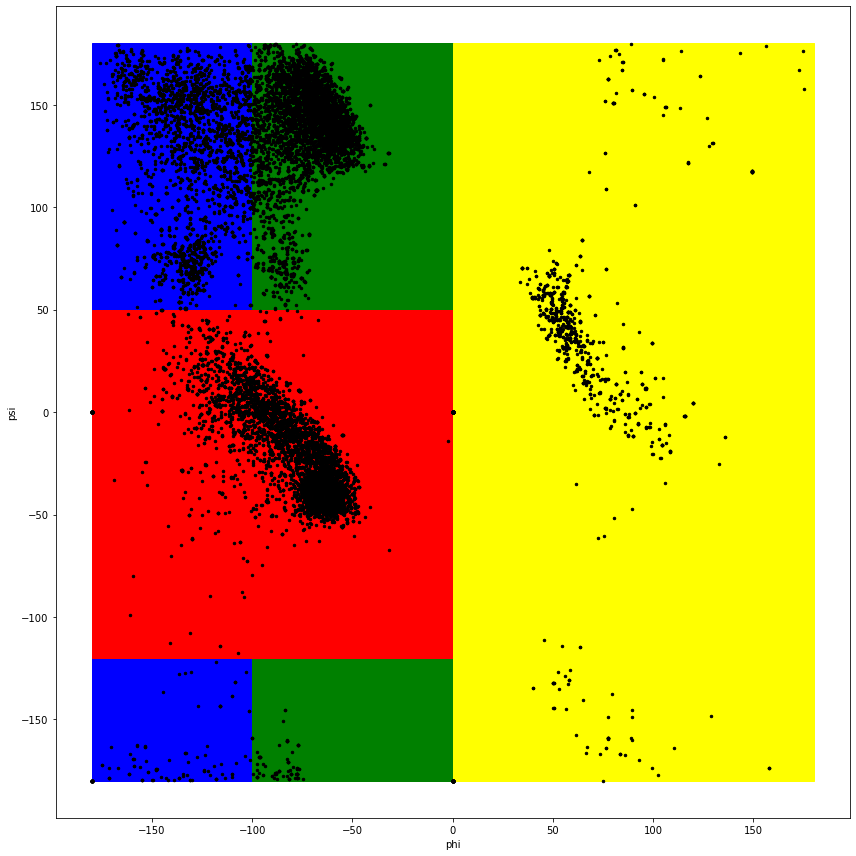

In [12]:
# Plot Ramachandran SS regions
f, axes = plt.subplots(1, len(rama), figsize=(12, 12))
axes = np.array(axes).reshape(-1)  # Hack to give consistency for single/multiple suplots (-1 force reshape to infer dimensions)
for ax, chain_id in zip(axes, rama):

    # Plot SS regions
    for x, y, width, height, _, color in rama_ss_ranges:
        ax.add_patch(patches.Rectangle(
            (x, y),  # (x,y)
            width,  # width
            height,  # height
            color=color, zorder=0))  # transparency

    # Plot points
    ax.scatter(rama[chain_id][1], rama[chain_id][2], s=6, color='black', zorder=1)

    ax.set_xlabel('phi')
    ax.set_ylabel('psi')

plt.tight_layout()  # Remove figure padding
plt.savefig('data/{}_ramachandran_ss.png'.format(pdb_id), bbox_inches='tight')